scikit-fuzzy kütüphanesini yükler; bulanık mantık sistemleri geliştirmek için kullanılır.

In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.1 MB/s eta 0:00:00


Gerekli kütüphaneleri içe aktarır: veri analizi, görselleştirme, değerlendirme metrikleri, bulanık mantık ve veri bölme işlemleri için kullanılır.

In [ ]:
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split

'esnek.csv' dosyasını okuyarak bir DataFrame'e aktarır ve ilk 5 satırı görüntüler.

In [ ]:
df = pd.read_csv('esnek.csv')
df.head()

,anchor_ratio,trans_range,node_density,iterations,ale,sd_ale
0,30,15,200,40,0.773546,0.250555
1,15,15,100,70,0.911941,0.498329
2,30,15,100,50,0.814867,0.255546
3,15,20,100,20,1.435332,0.394603
4,30,15,100,40,1.265909,0.302943


'sd_ale' sütunu varsa DataFrame'den siler; yoksa hata vermez (güvenli silme işlemi).

In [ ]:
df = df.drop(columns=['sd_ale'], errors='ignore')

Veri kümesindeki sayısal sütunların istatistiksel özetini (ortalama, std, min, max vb.) yazdırır.

In [ ]:
print(df.describe())

       anchor_ratio  trans_range  node_density  iterations         ale
count    107.000000   107.000000    107.000000  107.000000  107.000000
mean      20.523364    17.878505    159.813084   47.887850    0.983471
std        6.739556     3.107235     71.189109   24.668874    0.408313
min       10.000000    12.000000    100.000000   14.000000    0.394029
25%       15.000000    15.000000    100.000000   30.000000    0.655368
50%       18.000000    17.000000    100.000000   40.000000    0.899102
75%       30.000000    20.000000    200.000000   70.000000    1.196418
max       30.000000    25.000000    300.000000  100.000000    2.568407


Tüm özellikler (sütunlar) için ayrı ayrı yatay boxplot'lar çizerek dağılımı ve olası aykırı değerleri görselleştirir.

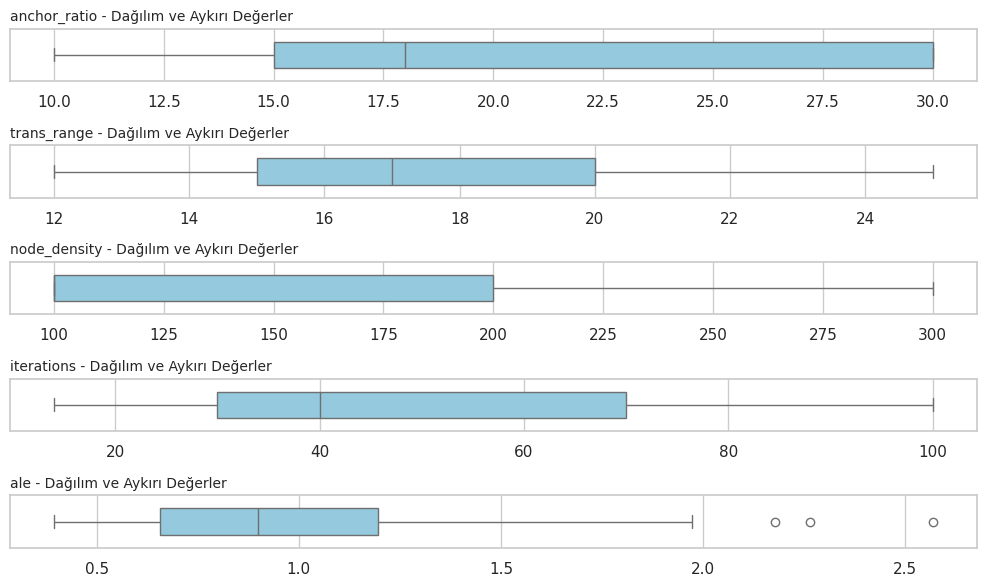

In [ ]:
# Grafik stilini belirle
sns.set(style="whitegrid", palette="pastel")

# Her değişken için ayrı boxplot çiz (yatay)
plt.figure(figsize=(10, 6))
for i, column in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i + 1)
    sns.boxplot(x=df[column], color="skyblue", width=0.5)
    plt.title(f"{column} - Dağılım ve Aykırı Değerler", fontsize=10, loc="left")
    plt.xlabel("")  # x-label’leri kaldır
    plt.tight_layout(pad=1.0)

# Tümünü göster
plt.show()

Girdi ve çıktı değişkenlerinin evrenlerini tanımlar; bu aralıklar üzerinde bulanık üyelik fonksiyonları tanımlanacaktır.

In [ ]:
# Üyelik fonksiyonu tanımlama
# Girdiler
anchor_ratio = ctrl.Antecedent(np.arange(10, 30.1, 0.5), 'anchor_ratio')
trans_range = ctrl.Antecedent(np.arange(12, 25.1, 0.5), 'trans_range')
node_density = ctrl.Antecedent(np.arange(100, 301, 10), 'node_density')
iterations = ctrl.Antecedent(np.arange(15, 101, 5), 'iterations')

# Çıktı
ale = ctrl.Consequent(np.arange(0.4, 2.57, 0.01), 'ale')

Üçgen (triangular) ve Gauss (gaussian) üyelik fonksiyonlarını tanımlayan fonksiyonlar yazılmıştır.

In [ ]:
# Triangular üyelik fonksiyonları
def define_triangular_mfs():
    anchor_ratio['low'] = fuzz.trimf(anchor_ratio.universe, [10, 10, 18])
    anchor_ratio['medium'] = fuzz.trimf(anchor_ratio.universe, [15, 20, 25])
    anchor_ratio['high'] = fuzz.trimf(anchor_ratio.universe, [22, 30, 30])

    trans_range['low'] = fuzz.trimf(trans_range.universe, [12, 12, 16])
    trans_range['medium'] = fuzz.trimf(trans_range.universe, [14, 17, 20])
    trans_range['high'] = fuzz.trimf(trans_range.universe, [18, 25, 25])

    node_density['low'] = fuzz.trimf(node_density.universe, [100, 100, 150])
    node_density['medium'] = fuzz.trimf(node_density.universe, [120, 180, 220])
    node_density['high'] = fuzz.trimf(node_density.universe, [200, 300, 300])

    iterations['low'] = fuzz.trimf(iterations.universe, [10, 10, 30])
    iterations['medium'] = fuzz.trimf(iterations.universe, [20, 50, 70])
    iterations['high'] = fuzz.trimf(iterations.universe, [60, 100, 100])

    ale['low'] = fuzz.trimf(ale.universe, [0.4, 0.4, 0.9])
    ale['medium'] = fuzz.trimf(ale.universe, [0.7, 1.0, 1.3])
    ale['high'] = fuzz.trimf(ale.universe, [1.2, 2.0, 2.0])

# Gauss üyelik fonksiyonları
def define_gaussian_mfs():
    anchor_ratio['low'] = fuzz.gaussmf(anchor_ratio.universe, 12, 2)
    anchor_ratio['medium'] = fuzz.gaussmf(anchor_ratio.universe, 20, 2)
    anchor_ratio['high'] = fuzz.gaussmf(anchor_ratio.universe, 28, 2)

    trans_range['low'] = fuzz.gaussmf(trans_range.universe, 13, 1.5)
    trans_range['medium'] = fuzz.gaussmf(trans_range.universe, 17, 2)
    trans_range['high'] = fuzz.gaussmf(trans_range.universe, 23, 2)

    node_density['low'] = fuzz.gaussmf(node_density.universe, 120, 20)
    node_density['medium'] = fuzz.gaussmf(node_density.universe, 180, 30)
    node_density['high'] = fuzz.gaussmf(node_density.universe, 260, 20)

    iterations['low'] = fuzz.gaussmf(iterations.universe, 25, 8)
    iterations['medium'] = fuzz.gaussmf(iterations.universe, 50, 10)
    iterations['high'] = fuzz.gaussmf(iterations.universe, 85, 10)

    ale['low'] = fuzz.gaussmf(ale.universe, 0.6, 0.1)
    ale['medium'] = fuzz.gaussmf(ale.universe, 1.0, 0.15)
    ale['high'] = fuzz.gaussmf(ale.universe, 1.8, 0.2)


Triangular üyelik fonksiyonlarını tanımla ve görselleştir

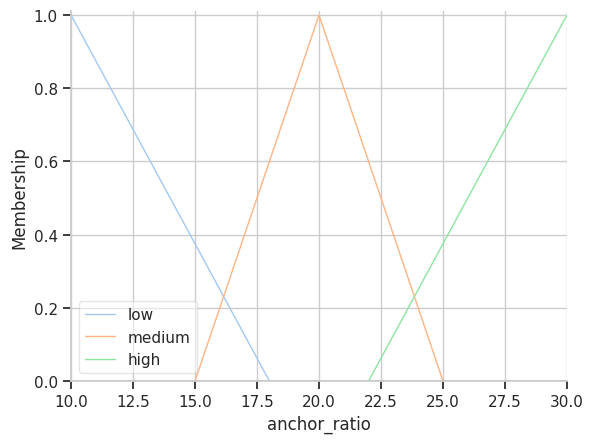

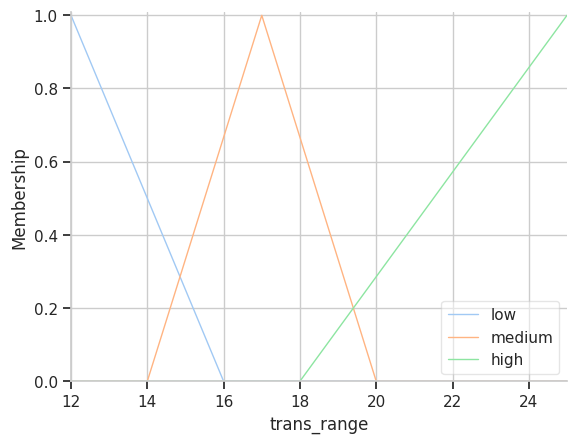

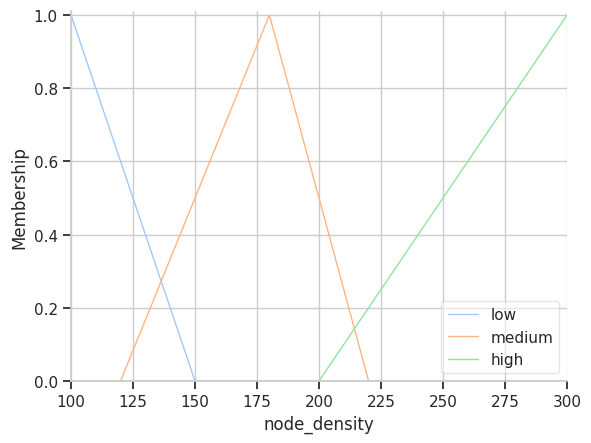

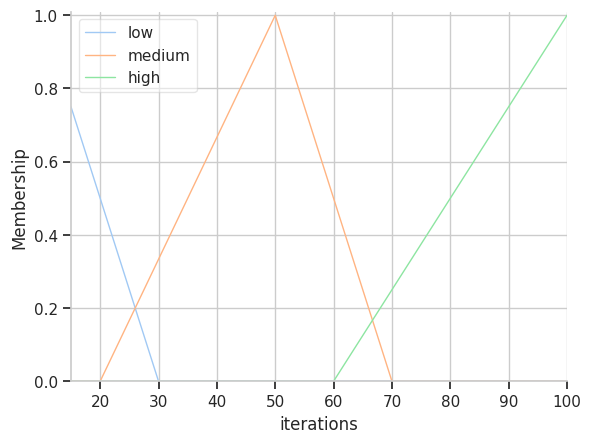

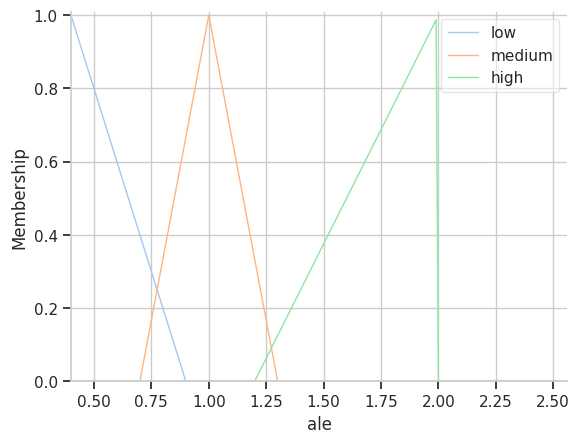

In [ ]:
# Triangular MF'leri tanımla
define_triangular_mfs()

# .view() ile göster
anchor_ratio.view()
trans_range.view()
node_density.view()
iterations.view()
ale.view()


Gaussian üyelik fonksiyonlarını tanımla ve görselleştir

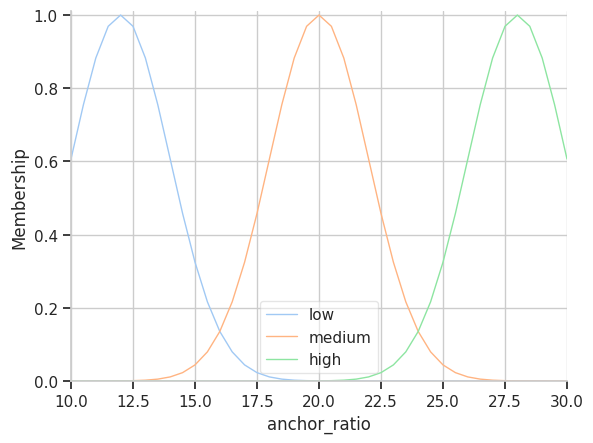

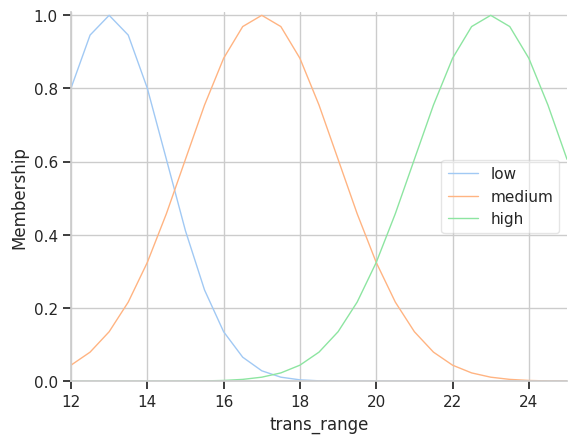

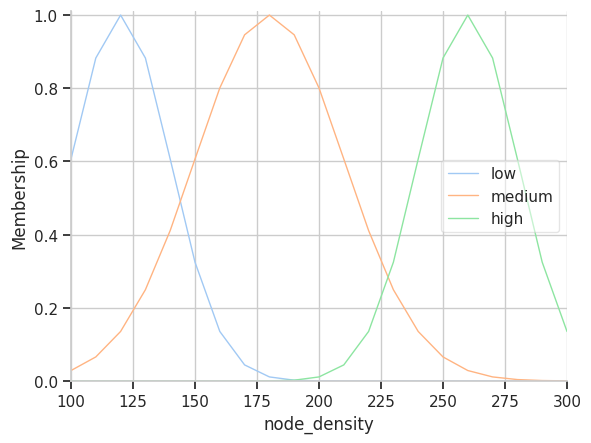

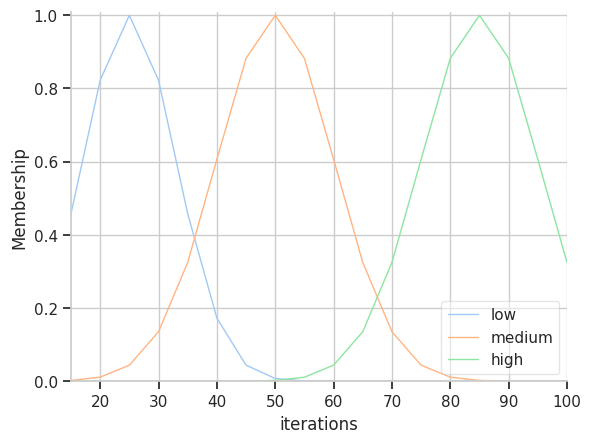

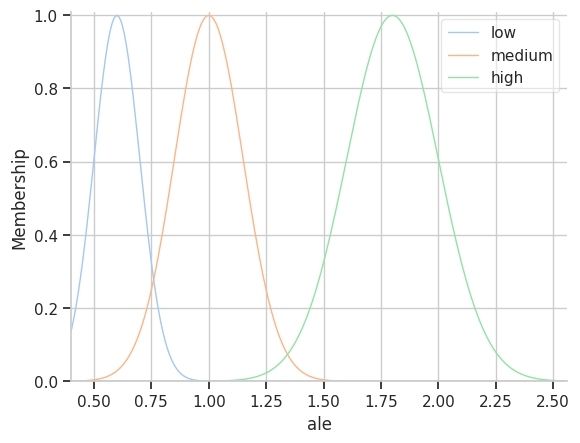

In [ ]:
# Gaussian MF'leri tanımla
define_gaussian_mfs()

# .view() ile göster
anchor_ratio.view()
trans_range.view()
node_density.view()
iterations.view()
ale.view()


Giriş değişkenlerinin farklı üyelik durumlarına göre çıktı ale için fuzzy kuralların tanımlanması yapılır

In [ ]:
def define_rules():
    return [
        ctrl.Rule(anchor_ratio['low'] & trans_range['low'] & node_density['low'] & iterations['low'], ale['high']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['medium'] & node_density['low'] & iterations['medium'], ale['medium']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['medium'] & node_density['medium'] & iterations['high'], ale['low']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['high'] & node_density['low'] & iterations['medium'] , ale['medium']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['high'] & node_density['medium'] & iterations['low'], ale['low']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['high'] & node_density['medium'] & iterations['high'], ale['low']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['high'] & node_density['medium'] & iterations['medium'], ale['low']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['low'] & node_density['high'] & iterations['high'], ale['low']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['medium'] & node_density['high'] & iterations['medium'], ale['low']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['high'] & node_density['high'] & iterations['medium'], ale['low']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['medium'] & node_density['medium'] & iterations['medium'], ale['low']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['high'] & node_density['low'] & iterations['high'], ale['medium']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['medium'] & node_density['medium'] & iterations['low'], ale['medium']),
        ctrl.Rule(anchor_ratio['low'] & trans_range['medium'] & node_density['high'] & iterations['low'], ale['low']),

        ctrl.Rule(anchor_ratio['medium'] & trans_range['medium'] & node_density['medium'] & iterations['medium'], ale['low']),
        ctrl.Rule(anchor_ratio['medium'] & trans_range['low'] & node_density['high'] & iterations['high'], ale['medium']),
        ctrl.Rule(anchor_ratio['medium'] & trans_range['high'] & node_density['high'] & iterations['medium'], ale['high']),
        ctrl.Rule(anchor_ratio['medium'] & trans_range['medium'] & node_density['high'] & iterations['high'], ale['low']),
        ctrl.Rule(anchor_ratio['medium'] & trans_range['low'] & node_density['medium'] & iterations['high'], ale['medium']),
        ctrl.Rule(anchor_ratio['medium'] & trans_range['high'] & node_density['high'] & iterations['low'], ale['high']),
        ctrl.Rule(anchor_ratio['medium'] & trans_range['high'] & node_density['low'] & iterations['medium'], ale['medium']),
        ctrl.Rule(anchor_ratio['medium'] & trans_range['high'] & node_density['medium'] & iterations['medium'], ale['low']),
        ctrl.Rule(anchor_ratio['medium'] & trans_range['high'] & node_density['medium'] & iterations['low'], ale['low']),

        ctrl.Rule(anchor_ratio['high'] & trans_range['low'] & node_density['high'] & iterations['medium'], ale['low']),
        ctrl.Rule(anchor_ratio['high'] & trans_range['high'] & node_density['low'] & iterations['medium'], ale['low']),
        ctrl.Rule(anchor_ratio['high'] & trans_range['low'] & node_density['medium'] & iterations['high'], ale['low']),
        ctrl.Rule(anchor_ratio['high'] & trans_range['low'] & node_density['medium'] & iterations['medium'], ale['medium']),
        ctrl.Rule(anchor_ratio['high'] & trans_range['high'] & node_density['medium'] & iterations['low'], ale['high']),
        ctrl.Rule(anchor_ratio['high'] & trans_range['low'] & node_density['medium'] & iterations['low'], ale['medium']),
        ctrl.Rule(anchor_ratio['high'] & trans_range['high'] & node_density['high'] & iterations['high'], ale['high']),
        ctrl.Rule(anchor_ratio['high'] & trans_range['high'] & node_density['low'] & iterations['high'], ale['low']),
        ctrl.Rule(anchor_ratio['high'] & trans_range['high'] & node_density['high'] & iterations['medium'], ale['low']),
        ctrl.Rule(anchor_ratio['high'] & trans_range['medium'] & node_density['high'] & iterations['low'], ale['low']),
        ctrl.Rule(anchor_ratio['high'] & trans_range['medium'] & node_density['low'] & iterations['high'], ale['high']),
        ctrl.Rule(anchor_ratio['high'] & trans_range['medium'] & node_density['medium'] & iterations['medium'], ale['low']),

        ctrl.Rule(node_density['low'] & iterations['low'], ale['high']),
        ctrl.Rule(trans_range['medium'] & node_density['low'], ale['medium']),
    ]

Belirtilen üyelik fonksiyonu türüne göre bulanık kontrol sistemini çalıştırır, sonucu hesaplar ve görselleştirir. Simülasyon görevi görür.


=== TRIANGULAR Üyelik Fonksiyonu ===
ALE Çıkışı (Triangular): 1.0000

=== GAUSSIAN Üyelik Fonksiyonu ===
ALE Çıkışı (Gaussian): 0.9890


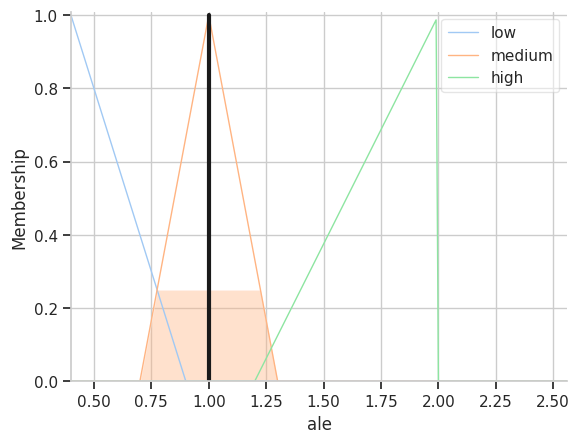

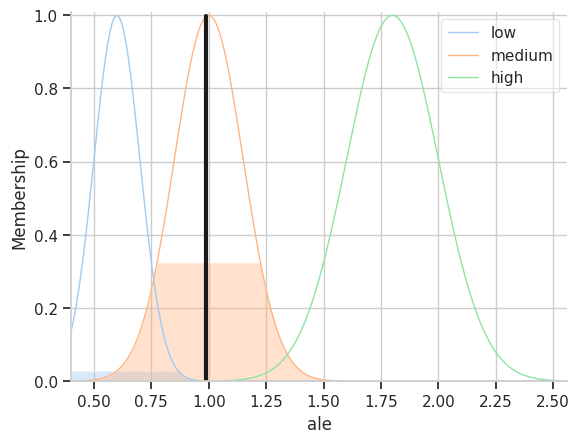

In [ ]:
def run_and_visualize(mf_type='triangular'):
    print(f"\n=== {mf_type.upper()} Üyelik Fonksiyonu ===")

    # Üyelik fonksiyonlarını tanımla
    if mf_type == 'triangular':
        define_triangular_mfs()
    elif mf_type == 'gaussian':
        define_gaussian_mfs()
    else:
        raise ValueError("mf_type 'triangular' veya 'gaussian' olmalıdır.")

    # Kuralları al ve kontrol sistemini kur
    rules = define_rules()
    ale_ctrl = ctrl.ControlSystem(rules)
    ale_simulator = ctrl.ControlSystemSimulation(ale_ctrl)

    # Giriş değerlerini ver
    ale_simulator.input['anchor_ratio'] = 15
    ale_simulator.input['trans_range'] = 20
    ale_simulator.input['node_density'] = 100
    ale_simulator.input['iterations'] = 70

    # Hesapla ve sonucu göster
    ale_simulator.compute()
    print(f"ALE Çıkışı ({mf_type.title()}): {ale_simulator.output['ale']:.4f}")

    # Sonucu görselleştir
    ale.view(sim=ale_simulator)

# Her iki MF tipi için çalıştır
run_and_visualize('triangular')
run_and_visualize('gaussian')


Verilen veri üzerinde farklı üyelik fonksiyonları ve defuzzifikasyon yöntemleri ile bulanık sistemi çalıştırır, tahminler üretir ve model performansını MAE ve RMSE ile değerlendirir.

In [ ]:
def run_fuzzy_system(X, y_true, mfs='triangular', defuzz='centroid'):
    # Üyelik fonksiyonlarını seç
    if mfs == 'triangular':
        define_triangular_mfs()
    else:
        define_gaussian_mfs()

    # Çıkış değişkeni için defuzzification yöntemi belirle
    ale.defuzzify_method = defuzz

    # Kuralları al
    rules = define_rules()

    # Modeli kur
    system = ctrl.ControlSystem(rules)
    simulator = ctrl.ControlSystemSimulation(system)

    predictions = []
    for i in range(len(X)):
        simulator.input['anchor_ratio'] = X.iloc[i, 0]
        simulator.input['trans_range'] = X.iloc[i, 1]
        simulator.input['node_density'] = X.iloc[i, 2]
        simulator.input['iterations'] = X.iloc[i, 3]

        simulator.compute()
        predictions.append(simulator.output['ale'])

    return np.array(predictions)

# %%
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Veriyi girdi (X) ve çıktı (y) olarak ayır
X = df.drop(columns=['ale'])
y_true = df['ale']

# Tüm kombinasyonları dene
for mf_type in ['triangular', 'gaussian']:
    for method in ['centroid', 'som', 'bisector', 'mom']:  # scikit-fuzzy default centroid, som (sum of max), bisector, mom diğer seçenek için custom gerekir
        print(f"==> MF: {mf_type.upper()}, Defuzz: {method}")
        preds = run_fuzzy_system(X, y_true, mfs=mf_type, defuzz=method)
        mae, rmse = evaluate(y_true, preds)
        print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

==> MF: TRIANGULAR, Defuzz: centroid
MAE: 0.2116, RMSE: 0.2975
==> MF: TRIANGULAR, Defuzz: som
MAE: 0.3370, RMSE: 0.4053
==> MF: TRIANGULAR, Defuzz: bisector
MAE: 0.2114, RMSE: 0.2949
==> MF: TRIANGULAR, Defuzz: mom
MAE: 0.2322, RMSE: 0.3274
==> MF: GAUSSIAN, Defuzz: centroid
MAE: 0.2216, RMSE: 0.3111
==> MF: GAUSSIAN, Defuzz: som
MAE: 0.3335, RMSE: 0.4431
==> MF: GAUSSIAN, Defuzz: bisector
MAE: 0.2179, RMSE: 0.3082
==> MF: GAUSSIAN, Defuzz: mom
MAE: 0.2365, RMSE: 0.3505
